In [2]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [35]:
class pMHC_TCRDataset(Dataset):
    def __init__(self, file_path, only_TCR_seq=False, only_experimental=False):
        # super(TCRDataset, self).__init__()
        df = pd.read_csv(file_path, index_col=0)
        # get the CDR3 region
        for chain in ["AseqCDR", "BseqCDR"]:
            # df[chain+"_1"] = df[chain].str.split("_").str[0]
            # df[chain+"_2"] = df[chain].str.split("_").str[1]
            df[chain+"_3"] = df[chain].str.split("_").str[2]
            df.drop(columns=[chain], inplace=True)

        # generate emulated negative samples 
        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
        # encode the CDR3 region
        len_map = {
            "AseqCDR_3": df["AseqCDR_3"].apply(lambda x: len(x)).max(),
            "BseqCDR_3": df["BseqCDR_3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR_3", "BseqCDR_3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

        # encode HLA type through one-hot encoding
        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

        X_features = torch.zeros((len(df),0))
        for seq in ["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]:
            # X_features = df[seq]
            # print(df[seq].values.shape)
            # convert the df[seq] into torch tensor
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)
        
        X = torch.cat((torch.from_numpy(X_HLA_encoded), X_features), dim=1)
        # encode the class label
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        if only_TCR_seq:
            self.X = X_features
            self.y = torch.from_numpy(y).float()
        else:
            self.X = X
            self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
class pMHC_TCR_model(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size=16, 
                 batch_size=32, 
                 num_layers=2, 
                 device="cpu", 
                 use_whole_data=False) -> None:
        super(pMHC_TCR_model, self).__init__()
        if use_whole_data:
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        # self.label = nn.Linear(hidden_size, 1)
        self.linear_layer = nn.Sequential(
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), int(hidden_size/4)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/4), int(hidden_size/8)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/8), 1),
        )

    def forward(self, input):
        if self.batch_size == 0:
            self.batch_size = input.shape[0]
            x = input.float()
            h_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
            # pred = self.label(output[-1])
            pred = self.linear_layer(output[-1])
        else:
            x = input.view(-1, self.batch_size, self.input_size).float()
            h_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            output, (hn, cn) = self.lstm(x, (h_0, c_0))
            # pred = self.label(output[-1])
            pred = self.linear_layer(output[-1])
        return pred

In [38]:
def train(fold, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, target.shape)
        output = output.to(torch.float32)
        target = target.to(torch.float32).view(-1, 1)
        # print(output.shape, target.shape)
        loss = nn.CrossEntropyLoss()(output.view(1,-1), target.view(1,-1))
        train_loss += loss.item() / len(train_loader.dataset)  # sum up batch loss
        pred = output.sigmoid().round()
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                fold, epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(train_loader.dataset)))
    # return the average loss
    # print(f"The batch size is {model.batch_size}")
    return train_loss, correct / len(train_loader.dataset)

def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).to(torch.float32)
            target = target.to(torch.float32).view(-1, 1)
            test_loss += nn.CrossEntropyLoss()(output.reshape(1,-1), target.reshape(1,-1)).item()  # sum up batch loss
            # print(test_loss)
            pred = output.sigmoid().round()
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= model.batch_size
    print(f"Test set for fold{fold}: Average Loss: \
          {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} \
          ({100. * correct / len(test_loader.dataset):.0f}%)")
    # print(f"The length of test_loader is {len(test_loader)}")
    return test_loss, correct / len(test_loader.dataset)

In [36]:
file_path = "~/data/project/data/seqData/230221.csv"
TCRData = pMHC_TCRDataset(file_path, only_TCR_seq=False, only_experimental=True)

Using cuda:0 for training
-------------------Fold 0-------------------
Train Fold/Epoch: 0/1 [0/1646 (0%)]	Loss: 0.098540
The batch size is 64
Test set for fold0: Average Loss:           13.9063, Accuracy: 106/1646           (6%)
Train Fold/Epoch: 0/2 [0/1646 (0%)]	Loss: 0.111173
The batch size is 64
Test set for fold0: Average Loss:           13.9712, Accuracy: 105/1646           (6%)
Train Fold/Epoch: 0/3 [0/1646 (0%)]	Loss: 0.101066
The batch size is 64
Test set for fold0: Average Loss:           14.0362, Accuracy: 104/1646           (6%)
Train Fold/Epoch: 0/4 [0/1646 (0%)]	Loss: 0.106120
The batch size is 64
Test set for fold0: Average Loss:           14.1012, Accuracy: 103/1646           (6%)
Train Fold/Epoch: 0/5 [0/1646 (0%)]	Loss: 0.128860
The batch size is 64
Test set for fold0: Average Loss:           13.9712, Accuracy: 105/1646           (6%)
Train Fold/Epoch: 0/6 [0/1646 (0%)]	Loss: 0.113700
The batch size is 64
Test set for fold0: Average Loss:           14.0362, Accuracy:

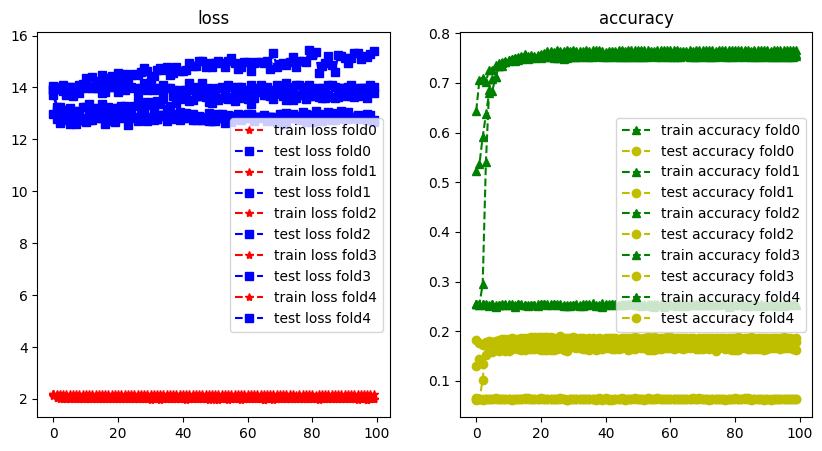

In [39]:
batch_size = 64
seq_length = 6
folds = 5
repeats = 12
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} for training")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = pMHC_TCR_model(input_size=237, hidden_size=16, batch_size=batch_size, num_layers=2, device=device, use_whole_data=False).to(device)
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
weights = torch.FloatTensor([5,6])
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=train_subsampler, drop_last=True)
        test_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=test_subsampler, drop_last=True)
    
    # print(f"The length of train_loader is {len(train_loader)}") # 34
    # print(f"The length of test_loader is {len(test_loader)}") # 8
    # print(f"The length of train_loader is {len(train_loader.dataset)}")
        
    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_loader, optimizer, epoch)
        test_losses, test_correct = test(fold, model, device, test_loader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        train_accuracy_history.append(train_correct)
        test_accuracy_history.append(test_correct)
    ax[0].plot(train_losses_history, "r*--" ,label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, "bs--", label=f"test loss fold{fold}")
    ax[1].plot(train_accuracy_history, "g^--", label=f"train accuracy fold{fold}")
    ax[1].plot(test_accuracy_history, "yo--", label=f"test accuracy fold{fold}")
    # ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    # ax[0].plot(test_losses_history, label=f"test loss fold{fold}")
    # ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    # ax[1].plot(test_accuracy_history, label=f"test accuracy fold{fold}")
ax[0].legend()
ax[1].legend()
# put the legend out of the figure, and adjust the position, prevent the figure from being covered
# ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save the figure
fig.savefig("/DATA/User/wuxinchao/project/pMHC-TCR/result/pMHC_without_em_without_encoder_loss_accuracy.png")

# Autoencoder model and dataset building

In [11]:
class pMHC_TCRDataset(Dataset):
    def __init__(self, file_path, only_TCR_seq=False, only_experimental=True):
        # super(TCRDataset, self).__init__()
        df = pd.read_csv(file_path, index_col=0)
        # get the CDR3 region
        for chain in ["AseqCDR", "BseqCDR"]:
            # df[chain+"_1"] = df[chain].str.split("_").str[0]
            # df[chain+"_2"] = df[chain].str.split("_").str[1]
            df[chain+"_3"] = df[chain].str.split("_").str[2]
            df.drop(columns=[chain], inplace=True)

        # generate emulated negative samples 
        if only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
        # encode the CDR3 region
        len_map = {
            "AseqCDR_3": df["AseqCDR_3"].apply(lambda x: len(x)).max(),
            "BseqCDR_3": df["BseqCDR_3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR_3", "BseqCDR_3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

        # encode HLA type through one-hot encoding
        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

        X_features = torch.zeros((len(df),0))
        for seq in ["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]:
            # X_features = df[seq]
            # print(df[seq].values.shape)
            # convert the df[seq] into torch tensor
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)
        
        X = torch.cat((torch.from_numpy(X_HLA_encoded), X_features), dim=1)
        # encode the class label
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        if only_TCR_seq:
            self.X = X_features
            self.y = torch.from_numpy(y).float()
        else:
            self.X = X
            self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [67]:
class TCR_autoencoder(nn.Module):
    '''
    The autoencoder for TCR sequence.
    For 230221 dataset, the sequnce length is 41 (20+21), and the input size is 41*5,
    the hidden size is 10. And the output size is 41*5. We apply convolutional neural
    network to encode the sequence, and apply deconvolutional neural network to decode
    the sequence. The activation function for convolutional neural network is ReLU,
    because it is a non-linear function, and it is easy to calculate the gradient.
    For the decoder, we use the same activation function as the encoder.

    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1):
        super(TCR_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # (batch_size, 5, 47)
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 24), based on the formula for conv1d: (W−F+2P)/S+1 = (47-3+2*1)/2+1 = 24
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # (batch_size, 10, 12)
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 6), based on the formula for conv1d: (W−F+2P)/S+1 = (12-3+2*1)/2+1 = 6
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # (batch_size, 20, 3)
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 3)
            nn.ConvTranspose1d(in_channels=20, out_channels=10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 6), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*2-2*1+3 = 6
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            # (batch_size, 10, 12)
            nn.ConvTranspose1d(in_channels=10, out_channels=5, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 5, 24), based on the formula for convtranspose1d: (W−1)S−2P+F = (12-1)*2-2*1+3 = 24
            # nn.ReLU(),
            # nn.Upsample(scale_factor=2),
            # # (batch_size, 5, 47)

        )

    def forward(self, x):
        encoded = self.encoder(x)
        print(encoded.shape)
        output = self.decoder(encoded)
        return encoded, output

torch.Size([16, 4, 12, 2])


RuntimeError: Given input size per channel: (21 x 1). Calculated output size per channel: (39 x -1). Output size is too small

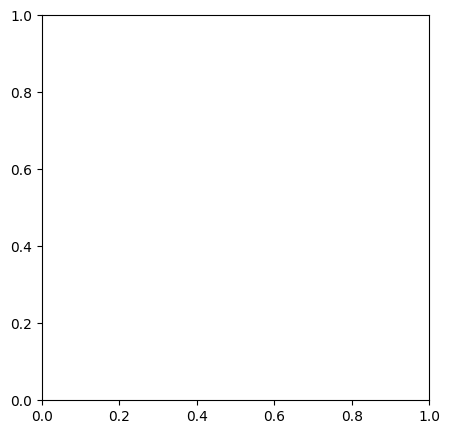

In [68]:
# training the autoencoder to encode the TCR sequence
def train_autoencoder(model, train_loader, optimizer, criterion, epoch):
    model.train()
    TCR_encode_losses = []
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 1, 47, 5)
        optimizer.zero_grad()
        _, output = model(data)
        print(output.shape, data.shape)
        loss = criterion(output, data)
        TCR_encode_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return TCR_encode_losses / len(model.batch_size)

epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 2

# train the autoencoder
TCRData = pMHC_TCRDataset(file_path, only_TCR_seq=True, only_experimental=True)
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TCR_encode_losses = []
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_autoencoder(model, train_loader, optimizer, criterion, epoch)
    TCR_encode_losses.append(TCR_encode_loss)
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [ ]:
# apply the model to encode the TCR sequence
TCR_encoded = []


# Use Only Experimental Data

In [ ]:
# # not use 
# # The input size is 47*5, the hidden size is 10, we use two convolutional layers
#         # to encode the sequence. The first layer: input_channel=5, output_channel=3,
#         # kernel size is 5, stride is 2, padding is 1.
#         # Based on the formula: (W-F+2P)/S + 1 = (47-5+2*1)/2 + 1 = 23
#         # The second layer: input_channel=3, output_channel=1, kernel size is 5,
#         # stride is 2, padding is 1.
#         # Based on the formula: (W-F+2P)/S + 1 = (23-5+2*1)/2 + 1 = 11
#         # The input shape of the encoder is (batch_size, channel, height, width=5): b, 1, 47, 5
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 8, kernel_size=kernel_size, stride=stride, padding=padding), 
#             # after the conv2d, the size is 24, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1), 
#             # after the maxpooling, the size is 23, 2 
#             nn.Conv2d(8, 4, kernel_size=kernel_size, stride=stride, padding=padding), 
#             # after the conv2d, the size is 12, 1
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1), 
#             # after the maxpooling, the size is 11, 1
#         )
#         # For the decoder, we use the same structure as the encoder. But the ConvTranspose2d is
#         # the deconvolutional neural network. The input size is 11, the output size is 47*5.
#         # The first layer: input_channel=1, output_channel=3, kernel size is 5,
#         # stride is 2, padding is 1.
#         # Based on the formula: (W-1)*S - 2P + F + O = (11-1)*2 - 2*1 + 5 + 0 = 23
#         # The second layer: input_channel=3, output_channel=5, kernel size is 5,
#         # stride is 2, padding is 1.
#         # Based on the formula: (W-1)*S - 2P + F + O = (23-1)*2 - 2*1 + 5 + 0 = 47
        
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding), 
#             # after the convtranspose2d, the size is 23, 4
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, kernel_size=kernel_size, stride=stride, padding=padding), 
#             # after the convtranspose2d, the size is 47, 5
#             nn.ReLU(True),
#         )